### 라이브러리 불러오기

In [2]:
# 필요한 라이브러리 import
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### 데이터 확인하기

- trian data

In [4]:
train_df = pd.read_csv('/Users/project/delete_missing_values/train.csv')
train_df.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40


- test data

In [5]:
test_df = pd.read_csv('/Users/project/delete_missing_values/test.csv')
test_df.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77


- building_info data

In [6]:
building_info = pd.read_csv('/Users/project/delete_missing_values/building_info.csv')
building_info.head()

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,110634.00,39570.00,-,-,-
1,2,건물기타,122233.47,99000.00,-,-,-
2,3,건물기타,171243.00,113950.00,40,-,-
3,4,건물기타,74312.98,34419.62,60,-,-
4,5,건물기타,205884.00,150000.00,-,2557,1000


### 필요한 데이터만 남기기

- 모델을 훈련하고 테스트할 때는 두 데이터프레임의 열(column) 구조가 일치해야 한다.
- 훈련 데이터프레임의 열과 테스트 데이터프레임의 열이 일치하지 않으면 모델을 적용하거나 예측하는 과정에서 문제가 발생할 수 있다.
- 테스트 데이터프레임의 열 구조를 훈련 데이터프레임의 열 구조와 동일하게 만들어야 한다.

In [7]:
train_df.columns

Index(['num_date_time', '건물번호', '일시', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
       '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'],
      dtype='object')

In [8]:
test_df.columns

Index(['num_date_time', '건물번호', '일시', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)'], dtype='object')

- 일조, 일사 drop

In [9]:
train_df.drop(columns=['일조(hr)', '일사(MJ/m2)'], inplace=True)

In [10]:
train_df.columns

Index(['num_date_time', '건물번호', '일시', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
       '전력소비량(kWh)'],
      dtype='object')

- 일시 datetime으로 변환

In [11]:
def preprocess_csv(df, columns_order, datetime_column, datetime_format):
    # num_date_time drop
    df.drop(columns='num_date_time', inplace=True)

    # 일시 datetime으로 변환
    df[datetime_column] = pd.to_datetime(df[datetime_column], format=datetime_format)

    # 월, 일, 시간, 요일로 분리
    df['월'] = df[datetime_column].dt.month
    df['일'] = df[datetime_column].dt.day
    df['시간'] = df[datetime_column].dt.hour
    df['요일'] = df[datetime_column].dt.weekday

    df.drop(columns=datetime_column, inplace=True)

    df = df[columns_order]

    return df

In [12]:
datetime_column = ['건물번호', '월', '일', '요일', '시간', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '전력소비량(kWh)']

train_df = preprocess_csv(train_df, datetime_column, '일시', '%Y%m%d %H')
train_df.head()

,건물번호,월,일,요일,시간,기온(C),강수량(mm),풍속(m/s),습도(%),전력소비량(kWh)
0,1,6,1,2,0,18.6,NaN,0.9,42.0,1085.28
1,1,6,1,2,1,18.0,NaN,1.1,45.0,1047.36
2,1,6,1,2,2,17.7,NaN,1.5,45.0,974.88
3,1,6,1,2,3,16.7,NaN,1.4,48.0,953.76
4,1,6,1,2,4,18.4,NaN,2.8,43.0,986.40


In [13]:
datetime_column = ['건물번호', '월', '일', '요일', '시간', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)']

test_df = preprocess_csv(test_df, datetime_column, '일시', '%Y%m%d %H')
test_df.head()

,건물번호,월,일,요일,시간,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1,8,25,3,0,23.5,0.0,2.2,72
1,1,8,25,3,1,23.0,0.0,0.9,72
2,1,8,25,3,2,22.7,0.0,1.5,75
3,1,8,25,3,3,22.1,0.0,1.3,78
4,1,8,25,3,4,21.8,0.0,1.0,77


- 상관관계 확인

In [14]:
train_df.corr()['전력소비량(kWh)'].sort_values(ascending=False)

전력소비량(kWh)    1.000000
기온(C)         0.171190
풍속(m/s)       0.109954
시간            0.099594
월             0.055842
강수량(mm)       0.015386
일             0.009233
요일           -0.043600
습도(%)        -0.129546
건물번호         -0.180474
Name: 전력소비량(kWh), dtype: float64

### 결측치 확인하기

In [15]:
train_df.isna().sum()

건물번호               0
월                  0
일                  0
요일                 0
시간                 0
기온(C)              0
강수량(mm)       160069
풍속(m/s)           19
습도(%)              9
전력소비량(kWh)         0
dtype: int64

In [16]:
train_df.shape

(204000, 10)

In [17]:
test_df.isna().sum()

건물번호       0
월          0
일          0
요일         0
시간         0
기온(C)      0
강수량(mm)    0
풍속(m/s)    0
습도(%)      0
dtype: int64

- trian_df 결측치처리

1. 평균 또는 중간값으로 대체하기: 해당 열의 평균값 또는 중간값을 사용하여 결측치를 대체하는 방법
2. 회귀 모델 사용하기: 결측치가 있는 열을 다른 특성을 기반으로 예측하는 회귀 모델을 사용하여 대체
3. K-최근접 이웃(KNN) 기반 대체: KNN 알고리즘을 사용하여 결측치를 가진 데이터 포인트를 주변의 유사한 데이터 포인트를 활용하여 대체
4. 시계열 데이터의 경우 앞 또는 뒤 값으로 대체하기: 계열 데이터의 경우, 이전 시간대나 다음 시간대의 값으로 결측치를 대체
5. 다른 변수를 활용한 예측: 다른 변수들 간의 관계를 고려하여 결측치를 예측하는 모델을 만들어 활용

In [18]:
train_df['강수량(mm)'].shape

(204000,)

In [19]:
train_df[train_df['강수량(mm)'].isna()]

,건물번호,월,일,요일,시간,기온(C),강수량(mm),풍속(m/s),습도(%),전력소비량(kWh)
0,1,6,1,2,0,18.6,NaN,0.9,42.0,1085.28
1,1,6,1,2,1,18.0,NaN,1.1,45.0,1047.36
2,1,6,1,2,2,17.7,NaN,1.5,45.0,974.88
3,1,6,1,2,3,16.7,NaN,1.4,48.0,953.76
4,1,6,1,2,4,18.4,NaN,2.8,43.0,986.40
...,...,...,...,...,...,...,...,...,...,...
203995,100,8,24,2,19,23.1,NaN,0.9,86.0,881.04
203996,100,8,24,2,20,22.4,NaN,1.3,86.0,798.96
203997,100,8,24,2,21,21.3,NaN,1.0,92.0,825.12
203998,100,8,24,2,22,21.0,NaN,0.3,94.0,640.08


시계열 데이터의 경우 앞 또는 뒤 값으로 대체하기
- 시계열 데이터의 경우, 이전 시간대나 다음 시간대의 값으로 결측치를 대체하는 것이 일반적일 수 있다.

```python
def missing_values(df, columns, method='previous'):
    for col in columns:
        if method == 'previous':
            df[col] = df[col].fillna(method='ffill')
        elif method == 'next':
            df[col] = df[col].fillna(method='bfill')
        else:
            raise ValueError("Invalid method. Use 'previous' or 'next'.")
```
- method: 결측치를 어떻게 채울지 지정하는 문자열 매개변수
    - previous, 결측치를 이전 값으로 채움 <br/>
      next, 다음 값으로 채움
- 결측치를 이전 값으로 채우는 것은 간단하고 편리한 방법일 수 있지만, 이 방법은 모델의 예측에 편향을 가져올 수 있다.
    - 특히 시계열 데이터에서는 시간에 따라 데이터의 분포나 패턴이 변할 수 있기 때문에, 단순히 이전 값으로 결측치를 채움으로써 모델이 실제 데이터의 변동성을 충분히 파악하지 못할 수 있음
- ex) 회귀 모델이나 시계열 모델을 사용할 수 있다. 이러한 방법은 데이터의 복잡성을 더 잘 반영하며, 모델링 결과의 신뢰도를 높일 수 있다.

In [36]:
from sklearn.impute import KNNImputer

# 결측치를 대체할 열들 선택
columns_to_impute = ['강수량(mm)', '풍속(m/s)', '습도(%)']

# KNNImputer 모델 생성
imputer = KNNImputer(n_neighbors=15)  # 이웃의 개수를 설정 7.169
# 결측치 대체
train_df_imputed = train_df.copy()
train_df_imputed[columns_to_impute] = imputer.fit_transform(train_df[columns_to_impute])

print("Original DataFrame:")
print(train_df.isna().sum())
print("\nDataFrame with Imputed Values:")
print(train_df_imputed.isna().sum())

Original DataFrame:
건물번호               0
월                  0
일                  0
요일                 0
시간                 0
기온(C)              0
강수량(mm)       160069
풍속(m/s)           19
습도(%)              9
전력소비량(kWh)         0
dtype: int64

DataFrame with Imputed Values:
건물번호          0
월             0
일             0
요일            0
시간            0
기온(C)         0
강수량(mm)       0
풍속(m/s)       0
습도(%)         0
전력소비량(kWh)    0
dtype: int64


- KNNImputer: k-최근접 이웃(KNN, k-Nearest Neighbors) 알고리즘을 사용하여 결측치를 예측하는 데 사용되는 scikit-learn 라이브러리의 클래스
    - KNNImputer 주요특징
        - KNN 알고리즘 활용: KNN은 주어진 데이터 포인트 주변의 가장 가까운 k 개의 이웃을 찾아 그들의 값을 기반으로 결측치를 예측한다. <br/> 
        이웃들의 값을 평균이나 중앙값과 같은 방식으로 활용하여 예측한다.
        - 이웃의 수 설정: KNNImputer에서의 'n-neighbors' 매개변수를 통해 이웃의 개수를 설정할 수 있다. <br/>
        작은 k값은 더 민감한 예측을 만들고, 큰 k값은 보다 부드러운 예측을 만들어낸다.
        - 거리 계산: KNNImputer는 예측할 때 각 데이터 포인트 사이의 거리를 계산한다. <br/>
        이 거리는 주로 유클리드 거리 또는 맨하탄 거리 등으로 계산된다.
        - 가중치 설정: KNNImputer는 예측할 때 이웃들의 가중치를 설정할 수 있는 옵션도 제공한다. <br/>
        이 가중치는 예측에 어떤 데이터 포인트가 얼마나 기여할지 결정한다.
- KNNImputer는 주로 수치형 데이터에서 결측치를 처리할 때 사용되며, 주변 데이터 포인트의 값을 참조하여 결측치를 예측하므로 패턴이나 분포를 고려하여 결측치를 대체할 수 있다.

In [21]:
train_df_imputed['강수량(mm)'].value_counts()

강수량(mm)
0.00     114885
0.04       6754
0.10       5460
0.08       4275
0.20       3114
          ...  
21.70         1
37.20         1
23.40         1
50.00         1
47.50         1
Name: count, Length: 537, dtype: int64

### 모델링

In [22]:
train_df_imputed.columns

Index(['건물번호', '월', '일', '요일', '시간', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
       '전력소비량(kWh)'],
      dtype='object')

- 데이터 분할

In [37]:
X_train = train_df_imputed.drop(['전력소비량(kWh)'], axis=1)
y_train = train_df_imputed['전력소비량(kWh)']
X_test = test_df

### 스케일링

In [21]:
from sklearn.preprocessing import StandardScaler

def standard_scaling(data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data

X_train_scaled = standard_scaling(X_train)
X_test_scaled = standard_scaling(X_test)

- 랜덤포레스트

In [38]:
from sklearn.ensemble import RandomForestRegressor

# 모델 생성
rfr_model = RandomForestRegressor()

# 모델 학습
rfr_model.fit(X_train, y_train)

# 테스트 데이터 예측
rfr_pred = rfr_model.predict(X_test)

# 결과 출력
print("Predicted Power Consumption on Test Data:", rfr_pred)

Predicted Power Consumption on Test Data: [2038.3824 2108.3088 1975.272  ...  716.7336  622.1664  484.8744]


In [22]:
from sklearn.ensemble import RandomForestRegressor

# 모델 생성
rfr_model = RandomForestRegressor()

# 모델 학습
rfr_model.fit(X_train_scaled, y_train)

# 테스트 데이터 예측
rfr_pred = rfr_model.predict(X_test_scaled)

# 결과 출력
print("Predicted Power Consumption on Test Data:", rfr_pred)

Predicted Power Consumption on Test Data: [1610.592  1530.0984 1536.2952 ...  819.2304  712.0344  553.8864]


- GridSearch
    - param_grid: 설정한 하이퍼파라미터 후보들로 그리드 서치를 수행
    - cv: 교차 검증을 위한 폴드의 개수
    - n_jobs: 병렬 처리를 위한 코어의 개수
        - -1로 설정하면 가능한 모든 코어를 활용
```python
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# 모델 생성
rfr_model = RandomForestRegressor()

# 탐색할 하이퍼파라미터 후보들 설정
param_grid = {
    'n_estimators': [50, 100, 200],      # 결정 트리 개수
    'max_depth': [None, 10, 20],         # 결정 트리의 최대 깊이
    'min_samples_split': [2, 5, 10],     # 내부 노드를 분할하는 데 필요한 최소 샘플 수
    'min_samples_leaf': [1, 2, 4]        # 리프 노드에 필요한 최소 샘플 수
}

# GridSearchCV를 사용하여 그리드 서치 수행
grid_search = GridSearchCV(estimator=rfr_model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 최적의 모델 출력
best_model = grid_search.best_estimator_
print("Best Model Parameters:", grid_search.best_params_)

# 테스트 데이터 예측
rfr_pred = best_model.predict(X_test)

# 결과 출력
print("Predicted Power Consumption on Test Data:", rfr_pred)
```

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# 모델 생성
rfr_model = RandomForestRegressor()

# 탐색할 하이퍼파라미터 후보들 설정
param_grid = {
    'n_estimators': [50, 100, 200],      # 결정 트리 개수
    'max_depth': [None, 10, 20],         # 결정 트리의 최대 깊이
    'min_samples_split': [2, 5, 10],     # 내부 노드를 분할하는 데 필요한 최소 샘플 수
    'min_samples_leaf': [1, 2, 4]        # 리프 노드에 필요한 최소 샘플 수
}

# GridSearchCV를 사용하여 그리드 서치 수행
grid_search = GridSearchCV(estimator=rfr_model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 최적의 모델 출력
best_model = grid_search.best_estimator_
print("Best Model Parameters:", grid_search.best_params_)

# 테스트 데이터 예측
rfr_pred = best_model.predict(X_test)

# 결과 출력
print("Predicted Power Consumption on Test Data:", rfr_pred)


In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# 랜덤 포레스트 모델 생성
rf_model = RandomForestRegressor()

# 탐색할 하이퍼파라미터 그리드 설정
param_dist = {
    'n_estimators': np.arange(50, 300, 10),             # 트리의 개수 범위
    'max_features': ['auto', 'sqrt', 'log2'],           # 최대 특성 사용 범위
    'max_depth': [None] + list(np.arange(5, 30, 5)),    # 트리의 최대 깊이 범위
    'min_samples_split': [2, 5, 10],                    # 노드를 분할하기 위한 최소 샘플 수
    'min_samples_leaf': [1, 2, 4]                       # 리프 노드가 되기 위한 최소 샘플 수
}

# RandomizedSearchCV 설정
random_search = RandomizedSearchCV(
    estimator=rf_model,                 # 모델
    param_distributions=param_dist,     # 하이퍼파라미터 그리드
    n_iter=100,                         # 무작위 선택 횟수
    cv=5,                               # 교차 검증 폴드 수
    verbose=2,                          # 출력 레벨 (0: 조용, 1: 진행 상황 출력, 2: 상세 출력)
    n_jobs=-1                           # 병렬 처리 (-1: 모든 가능한 프로세스 사용)
)

# 랜덤 서치 수행
random_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 및 점수 출력
print("Best Hyperparameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=140; total time=  29.7s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=140; total time=  30.1s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=140; total time=  31.1s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=140; total time=  31.4s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=140; total time=  31.2s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=230; total time= 1.2min
[CV] END max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=230; total time= 1.2min
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=250; total time=   0.1s
[CV] END max_depth=5, max_features=auto, 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
135 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
41 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11

Best Hyperparameters: {'n_estimators': 240, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 15}
Best Score: -0.2424479280152286


In [31]:
# 최적의 하이퍼파라미터 및 점수 출력
print("Best Hyperparameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Best Hyperparameters: {'n_estimators': 240, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 15}
Best Score: -0.2424479280152286


- best_score는 모델의 교차 검증 점수로, 예측값과 실제값 간의 차이를 나타냅니다. 음수 값이므로 모델이 데이터를 어느 정도 잘 예측하고 있다고 볼 수 있다.

In [32]:
from sklearn.ensemble import RandomForestRegressor

# 모델 생성
rfr_model = RandomForestRegressor(n_estimators=240,
                                  min_samples_split=5,
                                  min_samples_leaf=4,
                                  max_features='sqrt',
                                  max_depth=15)

# 모델 학습
rfr_model.fit(X_train, y_train)

# 테스트 데이터 예측
rfr_pred = rfr_model.predict(X_test)

# 결과 출력
print("Predicted Power Consumption on Test Data:", rfr_pred)

Predicted Power Consumption on Test Data: [1816.68171348 1665.62257182 1725.81725966 ...  937.41500612  861.00297376
  734.16635835]


GridSearchCV
- 모든 가능한 조합을 탐색하는 완전 탐색 방식
- 지정한 하이퍼파라미터 그리드에서 가능한 모든 조합을 시도하며, 모든 조합에 대해 교차 검증을 수행
- 이 방식은 모든 경우의 수를 고려하기 때문에 정확한 최적의 조합을 찾을 수 있지만, 그만큼 수행 시간이 오래 걸릴수 있다.
<br/><br/>
RandomizedSearchCV
- 랜덤하게 선택된 조합을 사용하여 탐색하는 방식
- 정한 하이퍼파라미터 그리드에서 무작위로 조합을 선택하며, 이 선택된 조합에 대해 교차 검증을 수행
- 이 방식은 완전 탐색에 비해 더 빠르게 실행되지만, 최적의 조합을 찾을 수 있는 확률은 낮아질 수 있다.

- xgboost

In [25]:
from xgboost import XGBRegressor

# XGBoost 모델 생성
xgb_model = XGBRegressor()

# 모델 훈련
xgb_model.fit(X_train, y_train)

# 예측 수행
y_test_pred_xgb = xgb_model.predict(X_test)

# 결과 출력
print("Predicted Power Consumption on Test Data:", y_test_pred_xgb)

Predicted Power Consumption on Test Data: [2011.5867  1970.4691  1838.6703  ...  841.86237  646.48645  522.88495]


In [69]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# XGBoost 모델 정의
xgb_model = xgb.XGBRegressor()

# 탐색할 하이퍼파라미터 범위 설정
param_dist = {
    'n_estimators': [100, 200, 300],               # 결정 트리 개수
    'max_depth': [3, 4, 5, 6],                      # 트리의 최대 깊이
    'learning_rate': [0.01, 0.1, 0.2],              # 학습률
    'subsample': [0.8, 0.9, 1.0],                   # 데이터 샘플링 비율
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0], # 트리 생성 시 변수 샘플링 비율
    'gamma': [0, 1, 2],                             # 리프 노드에서 추가적으로 나뉘어질 수 있는 최소 손실 감소
    'reg_alpha': [0, 0.01, 0.1, 1],                 # L1 규제 (Lasso)
    'reg_lambda': [0, 0.01, 0.1, 1]                 # L2 규제 (Ridge)
}

# 랜덤 서치 수행
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, 
                                   n_iter=10, scoring='neg_mean_squared_error', cv=5)

# 랜덤 서치 실행
random_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 및 점수 출력
print("Best Hyperparameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)


Best Hyperparameters: {'subsample': 0.9, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 1, 'colsample_bytree': 0.7}
Best Score: -5940017.848023784


In [70]:
import xgboost as xgb

# 모델 생성
best_prams = {'subsample': 0.9, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 1, 'colsample_bytree': 0.7}
xgb_model = xgb.XGBRegressor(**best_params)

# 모델 훈련
xgb_model.fit(X_train, y_train)

# 예측 수행
y_test_pred_xgb = xgb_model.predict(X_test)

# 결과 출력
print("Predicted Power Consumption on Test Data:", y_test_pred_xgb)

Predicted Power Consumption on Test Data: [1914.9545  1833.1119  1823.5333  ...  483.60217  356.17566  324.45483]


- 신경망 회귀
    - loss: 모델의 예측과 실제 값 사이의 차이를 나타내는 지표
        - 이 값이 작을수록 모델의 예측이 실제 값과 가까워지고 있다는 것
    - val_loss: 모델이 검증 데이터를 사용하여 예측한 값과 실제 검증 데이터의 값 사이의 차이를 나타내는 지표
        - 모델이 과적합(overfitting)되지 않도록 평가
        - 검증 손실이 작을수록 모델이 더 좋은 일반화 성능을 가진다고 볼 수 있다.

In [44]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# 데이터 표준화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 신경망 모델 정의
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)  # 출력 레이어
])

# 모델 컴파일
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early Stopping 적용
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 훈련
history = model.fit(X_train_scaled, y_train, epochs=150, batch_size=100, verbose=1, validation_split=0.2, callbacks=[early_stopping])

# 예측 수행
y_test_pred = model.predict(X_test_scaled).flatten()

Epoch 1/150
1632/1632 [==============================] - 6s 3ms/step - loss: 7396086.0000 - val_loss: 1215629.8750
Epoch 2/150
1632/1632 [==============================] - 6s 4ms/step - loss: 6724933.0000 - val_loss: 1275578.3750
Epoch 3/150
1632/1632 [==============================] - 6s 4ms/step - loss: 6681369.0000 - val_loss: 1149078.7500
Epoch 4/150
1632/1632 [==============================] - 5s 3ms/step - loss: 6625738.0000 - val_loss: 1013329.9375
Epoch 5/150
1632/1632 [==============================] - 5s 3ms/step - loss: 6601154.5000 - val_loss: 1114582.2500
Epoch 6/150
1632/1632 [==============================] - 4s 3ms/step - loss: 6580590.5000 - val_loss: 1179957.3750
Epoch 7/150
1632/1632 [==============================] - 5s 3ms/step - loss: 6548312.5000 - val_loss: 816405.0000
Epoch 8/150
1632/1632 [==============================] - 9s 5ms/step - loss: 6149691.5000 - val_loss: 645836.0625
Epoch 9/150
1632/1632 [==============================] - 10s 6ms/step - loss: 5509

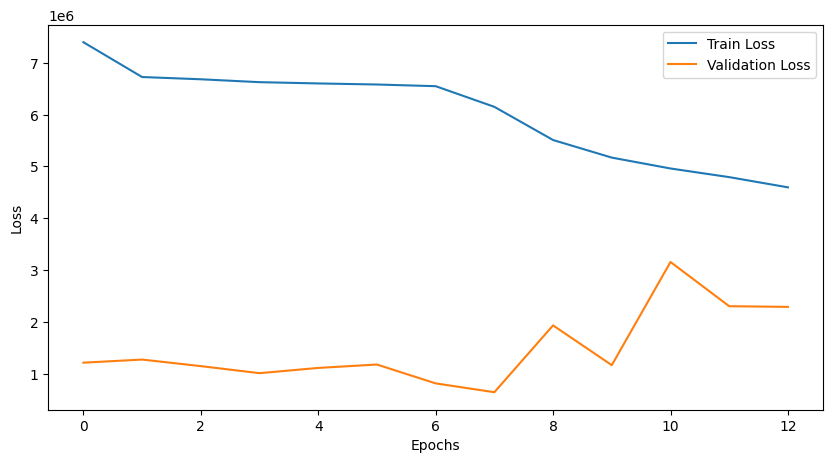

In [45]:
# 손실 및 정확도 추적
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 손실 및 정확도 그래프 시각화
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [26]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

# 데이터 표준화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 훈련 및 검증 데이터 분할
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

# 신경망 모델 정의
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_final.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)  # 출력 레이어
])

# 모델 컴파일
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early Stopping 적용
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 훈련
history = model.fit(X_train_final, y_train_final, epochs=100, batch_size=100, verbose=1, validation_data=(X_val, y_val), callbacks=[early_stopping])

# 검증 데이터로 예측 및 평가
y_val_pred = model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
print("Validation MSE:", val_mse)

# 테스트 데이터로 예측
y_test_pred = model.predict(X_test_scaled).flatten()


2023-08-14 16:10:19.019324: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
1632/1632 [==============================] - 4s 2ms/step - loss: 6117937.5000 - val_loss: 5494019.0000
Epoch 2/100
1632/1632 [==============================] - 3s 2ms/step - loss: 5475317.5000 - val_loss: 5179093.0000
Epoch 3/100
1632/1632 [==============================] - 3s 2ms/step - loss: 4910501.5000 - val_loss: 4542781.0000
Epoch 4/100
1632/1632 [==============================] - 3s 2ms/step - loss: 4407911.5000 - val_loss: 4216878.5000
Epoch 5/100
1632/1632 [==============================] - 3s 2ms/step - loss: 4203566.0000 - val_loss: 4092569.5000
Epoch 6/100
1632/1632 [==============================] - 3s 2ms/step - loss: 4111707.7500 - val_loss: 4038192.5000
Epoch 7/100
1632/1632 [==============================] - 3s 2ms/step - loss: 4018914.5000 - val_loss: 3900032.0000
Epoch 8/100
1632/1632 [==============================] - 3s 2ms/step - loss: 3943867.2500 - val_loss: 3850024.7500
Epoch 9/100
1632/1632 [==============================] - 3s 2ms/step - loss: 390

In [47]:
y_test_pred

array([1266.4667, 1121.4861, 1154.767 , ..., 1073.1805, 1050.0272,
        893.1804], dtype=float32)

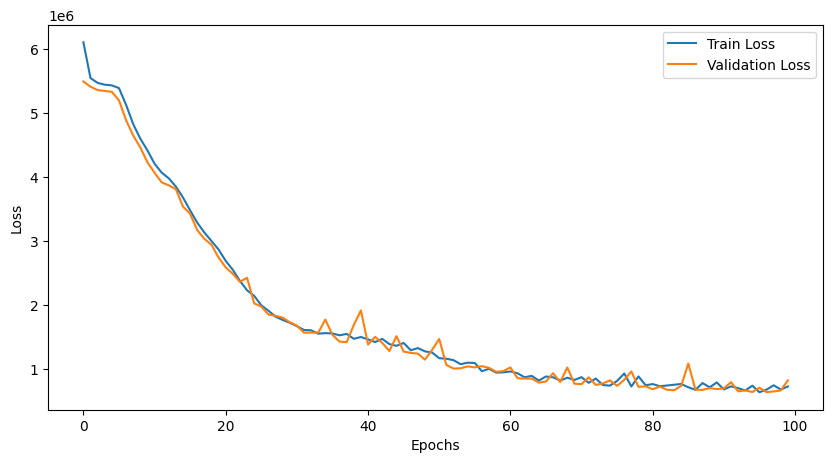

In [49]:
# 손실 및 정확도 추적
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 손실 및 정확도 그래프 시각화
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- 라쏘-릿지 회귀
    - alpha: 정규화 강도를 조절
        - 높은 값은 더 강한 정규화를 의미하며, 모델의 복잡도를 낮춘다.
        - 일반적으로 0에서 1 사이의 값을 사용하며, 값을 조정하여 최적의 정규화 강도를 찾아야 한다.
    - l1_ratio: 라쏘(L1)와 릿지(L2) 정규화의 비율
        - 0에 가까울수록 릿지, 1에 가까울수록 라쏘에 가까워진다.
        - 0.5로 설정하면 라쏘와 릿지를 반반씩 적용

In [27]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

# 모델 생성
model = ElasticNet(alpha=0.5, l1_ratio=0.5)

# 모델 학습
model.fit(X_train, y_train)

# 모델 예측
y_pred = model.predict(X_test)

# 결과 출력
print("Predicted Power Consumption on Test Data:", y_pred)

Predicted Power Consumption on Test Data: [3064.83335898 2910.02510542 2929.68239191 ... 1196.46619477 1285.00477996
 1102.55429173]


### file 저장

In [22]:
last_df = pd.read_csv('/Users/project/delete_missing_values/sample_submission.csv')
copy_df = pd.read_csv('/Users/project/delete_missing_values/sample_submission_1.csv')

In [40]:
def save_predictions_to_csv(predictions, filename, y_pred):
    predictions['answer'] = y_pred
    predictions.to_csv(filename, index=False)

# 예측값과 해당 시간 정보를 가지고 있는 DataFrame 생성
predictions_df = pd.DataFrame({
    'num_date_time': last_df['num_date_time'],  # 테스트 데이터의 시간 정보
})

# CSV 파일로 저장
save_predictions_to_csv(predictions_df, 'sample_submission.csv', rfr_pred)

In [ ]:
def predictions_to_csv(predictions, filename, y_pred_list):
    for i, y_pred in enumerate(y_pred_list, start=1):
        col_name = f'y_pred{i}'
        predictions[col_name] = y_pred
    predictions.to_csv(filename, index=False)

# 예측값과 해당 시간 정보를 가지고 있는 DataFrame 생성
predictions_df = pd.DataFrame({
    'num_date_time': copy_df['num_date_time'],  # 테스트 데이터의 시간 정보
})

# 예측값 리스트
y_pred_list = [rfr_pred, y_test_pred_xgb, y_test_pred, y_pred]  # 본인이 다른 모델로 예측한 결과

# CSV 파일로 저장
predictions_to_csv(predictions_df, 'sample_submission_2.csv', y_pred_list)
